In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [2]:
# plotting style (optional!)
import matplotlib as mpl
from matplotlib import rc
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mlmodern}'

mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)
mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)

mpl.rcParams['xtick.major.size'] = 10.0
mpl.rcParams['xtick.major.width'] = 1.75
mpl.rcParams['ytick.major.size'] = 10.0
mpl.rcParams['ytick.major.width'] = 1.75

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['xtick.major.pad'] = 10.0
mpl.rcParams['ytick.major.pad'] = 10.0

mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False

mpl.rcParams['xtick.minor.size'] = 5.0
mpl.rcParams['xtick.minor.width'] = 1.75
mpl.rcParams['ytick.minor.size'] = 5.0
mpl.rcParams['ytick.minor.width'] = 1.75

mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True

import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [3]:
# simple model for Gaia's astrometric uncertainty
def piecewise(x, a):
    return a*np.max([1.0*np.ones(len(x)), 10**(0.2*(x - 14.0))], axis=0)

# function to calculate sigma_fov as a function of distance and absolute G-band mag
def calc_sigma_fov(d, absGmag):
    appGmag = absGmag + 5.0*np.log10(d/10.0)
    
    # list/numpy array
    if type(appGmag) == list or type(appGmag) == np.ndarray:
        sigma_fovs = piecewise(appGmag, 53.89888779)
        return sigma_fovs
    
    # float
    return piecewise(np.array([appGmag]), 53.89888779)[0]

In [4]:
# function to calculate absolute G-band magnitude from stellar mass
def calc_absGmag(mass, coeff=np.array([16.91206805,  24.95258266,   4.0433877 , -13.63108438, 4.77092427])):
    return np.polyval(coeff, np.log10(mass))

In [5]:
# function whose root is the limiting distance 
def root_function(d, absGmag, mratio, a, N_sigma):
    return d * calc_sigma_fov(d, absGmag) - 1e6*mratio*a/N_sigma

# function to calculate limiting distance (absGmag and mratio are arrays and a is a float)
def calc_limiting_distance(absGmag, mratio, a, N_sigma, d_min=1e-10, d_max=1e10, tol=1e-8):
    limiting_distances = np.zeros(len(absGmag))
    for i in range(len(absGmag)):
        if root_function(d_min, absGmag[i], mratio[i], a, N_sigma) * root_function(d_max, absGmag[i], mratio[i], a, N_sigma) > 0:
            raise ValueError("The root is not bracketed in the given interval. Try adjusting d_min and d_max.")
            
        limiting_distances[i] = brentq(root_function, d_min, d_max, args=(absGmag[i], mratio[i], a, N_sigma), xtol=tol)
    
    return limiting_distances

In [6]:
# function to plot limiting distance for mp = 1, 3, 10 M_J and some fixed semi-major axis
def plot_panel(ax1, ax2, a, N_sigma, line_labels=True, remove_G_20_label=False):
    mplanetvals = np.array([1, 3, 10])  # planet masses in Jupiter masses
    mstarvals = np.linspace(0.1,2,1000) # stellar masses
    absGmagvals = calc_absGmag(mstarvals)
    colors = ['indianred', 'royalblue', 'mediumseagreen']
    
    for i in range(len(mplanetvals)):
        mplanet = mplanetvals[i]
        mratiovals = 0.0009542*mplanet/mstarvals
    
        d_limit = calc_limiting_distance(absGmagvals, mratiovals, a, N_sigma=N_sigma)
        appGmag_limit = absGmagvals + 5.0*np.log10(d_limit/10.0)
        too_long_mask = (a > 4.48555*mstarvals**(1.0/3.0)) # P > 9.5 years threshold
        
        if line_labels:
            ax1.plot(mstarvals, d_limit, '-', lw=3, c=colors[i], label=rf'$m_p = {mplanet}\,M_\mathrm{{J}}$')
        else:
            ax1.plot(mstarvals, d_limit, '-', lw=3, c=colors[i])
        
        if np.any(too_long_mask):
            ax1.plot(mstarvals[too_long_mask], d_limit[too_long_mask], 'k-', linewidth=9, alpha=0.2)
            
        if i == len(mplanetvals)-1:
            ax1.set_xlabel(r'$\mathrm{Stellar~mass}~M_\star~[M_\odot]$', labelpad=7, fontsize=32)
            ax1.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
            ax1.set_xticklabels([r'', r'$0.4$', r'', r'$0.8$', r'', r'$1.2$', r'', r'$1.6$', r'', r'$2.0$'])
        
        ax1.set_ylabel(r'$\mathrm{Maximum}~r~\mathrm{[pc]}$', fontsize=32, labelpad=7)
        ax1.set_yscale('log')
        ax1.set_xlim(0.1,2)
        ax1.set_ylim(4, 4e3)
        if line_labels:
            ax1.legend(loc='best', scatterpoints=1, handletextpad=0.2, borderaxespad=0.3, frameon=False, fontsize=26)

        if line_labels:
            ax2.plot(mstarvals, appGmag_limit, '-', lw=3, c=colors[i], label=rf'$m_p = {mplanet}\,M_\mathrm{{J}}$')
        else:
            ax2.plot(mstarvals, appGmag_limit, '-', lw=3, c=colors[i])
        
        if np.any(too_long_mask):
            ax2.plot(mstarvals[too_long_mask], appGmag_limit[too_long_mask], 'k-', linewidth=9, alpha=0.2)
        
        if i == len(mplanetvals)-1:
            ax2.set_xlabel(r'$\mathrm{Stellar~mass}~M_\star~[M_\odot]$', fontsize=32)
            ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
            ax2.set_xticklabels([r'', r'$0.4$', r'', r'$0.8$', r'', r'$1.2$', r'', r'$1.6$', r'', r'$2.0$'])
        
        ax2.set_ylabel(r'$\mathrm{Maximum}~G$', labelpad=7, fontsize=32)
        if remove_G_20_label:
            ax2.set_yticks([6, 8, 10, 12, 14, 16, 18, 20])
            ax2.set_yticklabels([r'$6$', r'$8$', r'$10$', r'$12$', r'$14$', r'$16$', r'$18$', r''])
            
        ax2.set_xlim(0.1,2)
        ax2.set_ylim(5.0,20.5)
        if line_labels:
            ax2.legend(loc='best', scatterpoints=1, handletextpad=0.2, borderaxespad=0.3, frameon=False, fontsize=26)

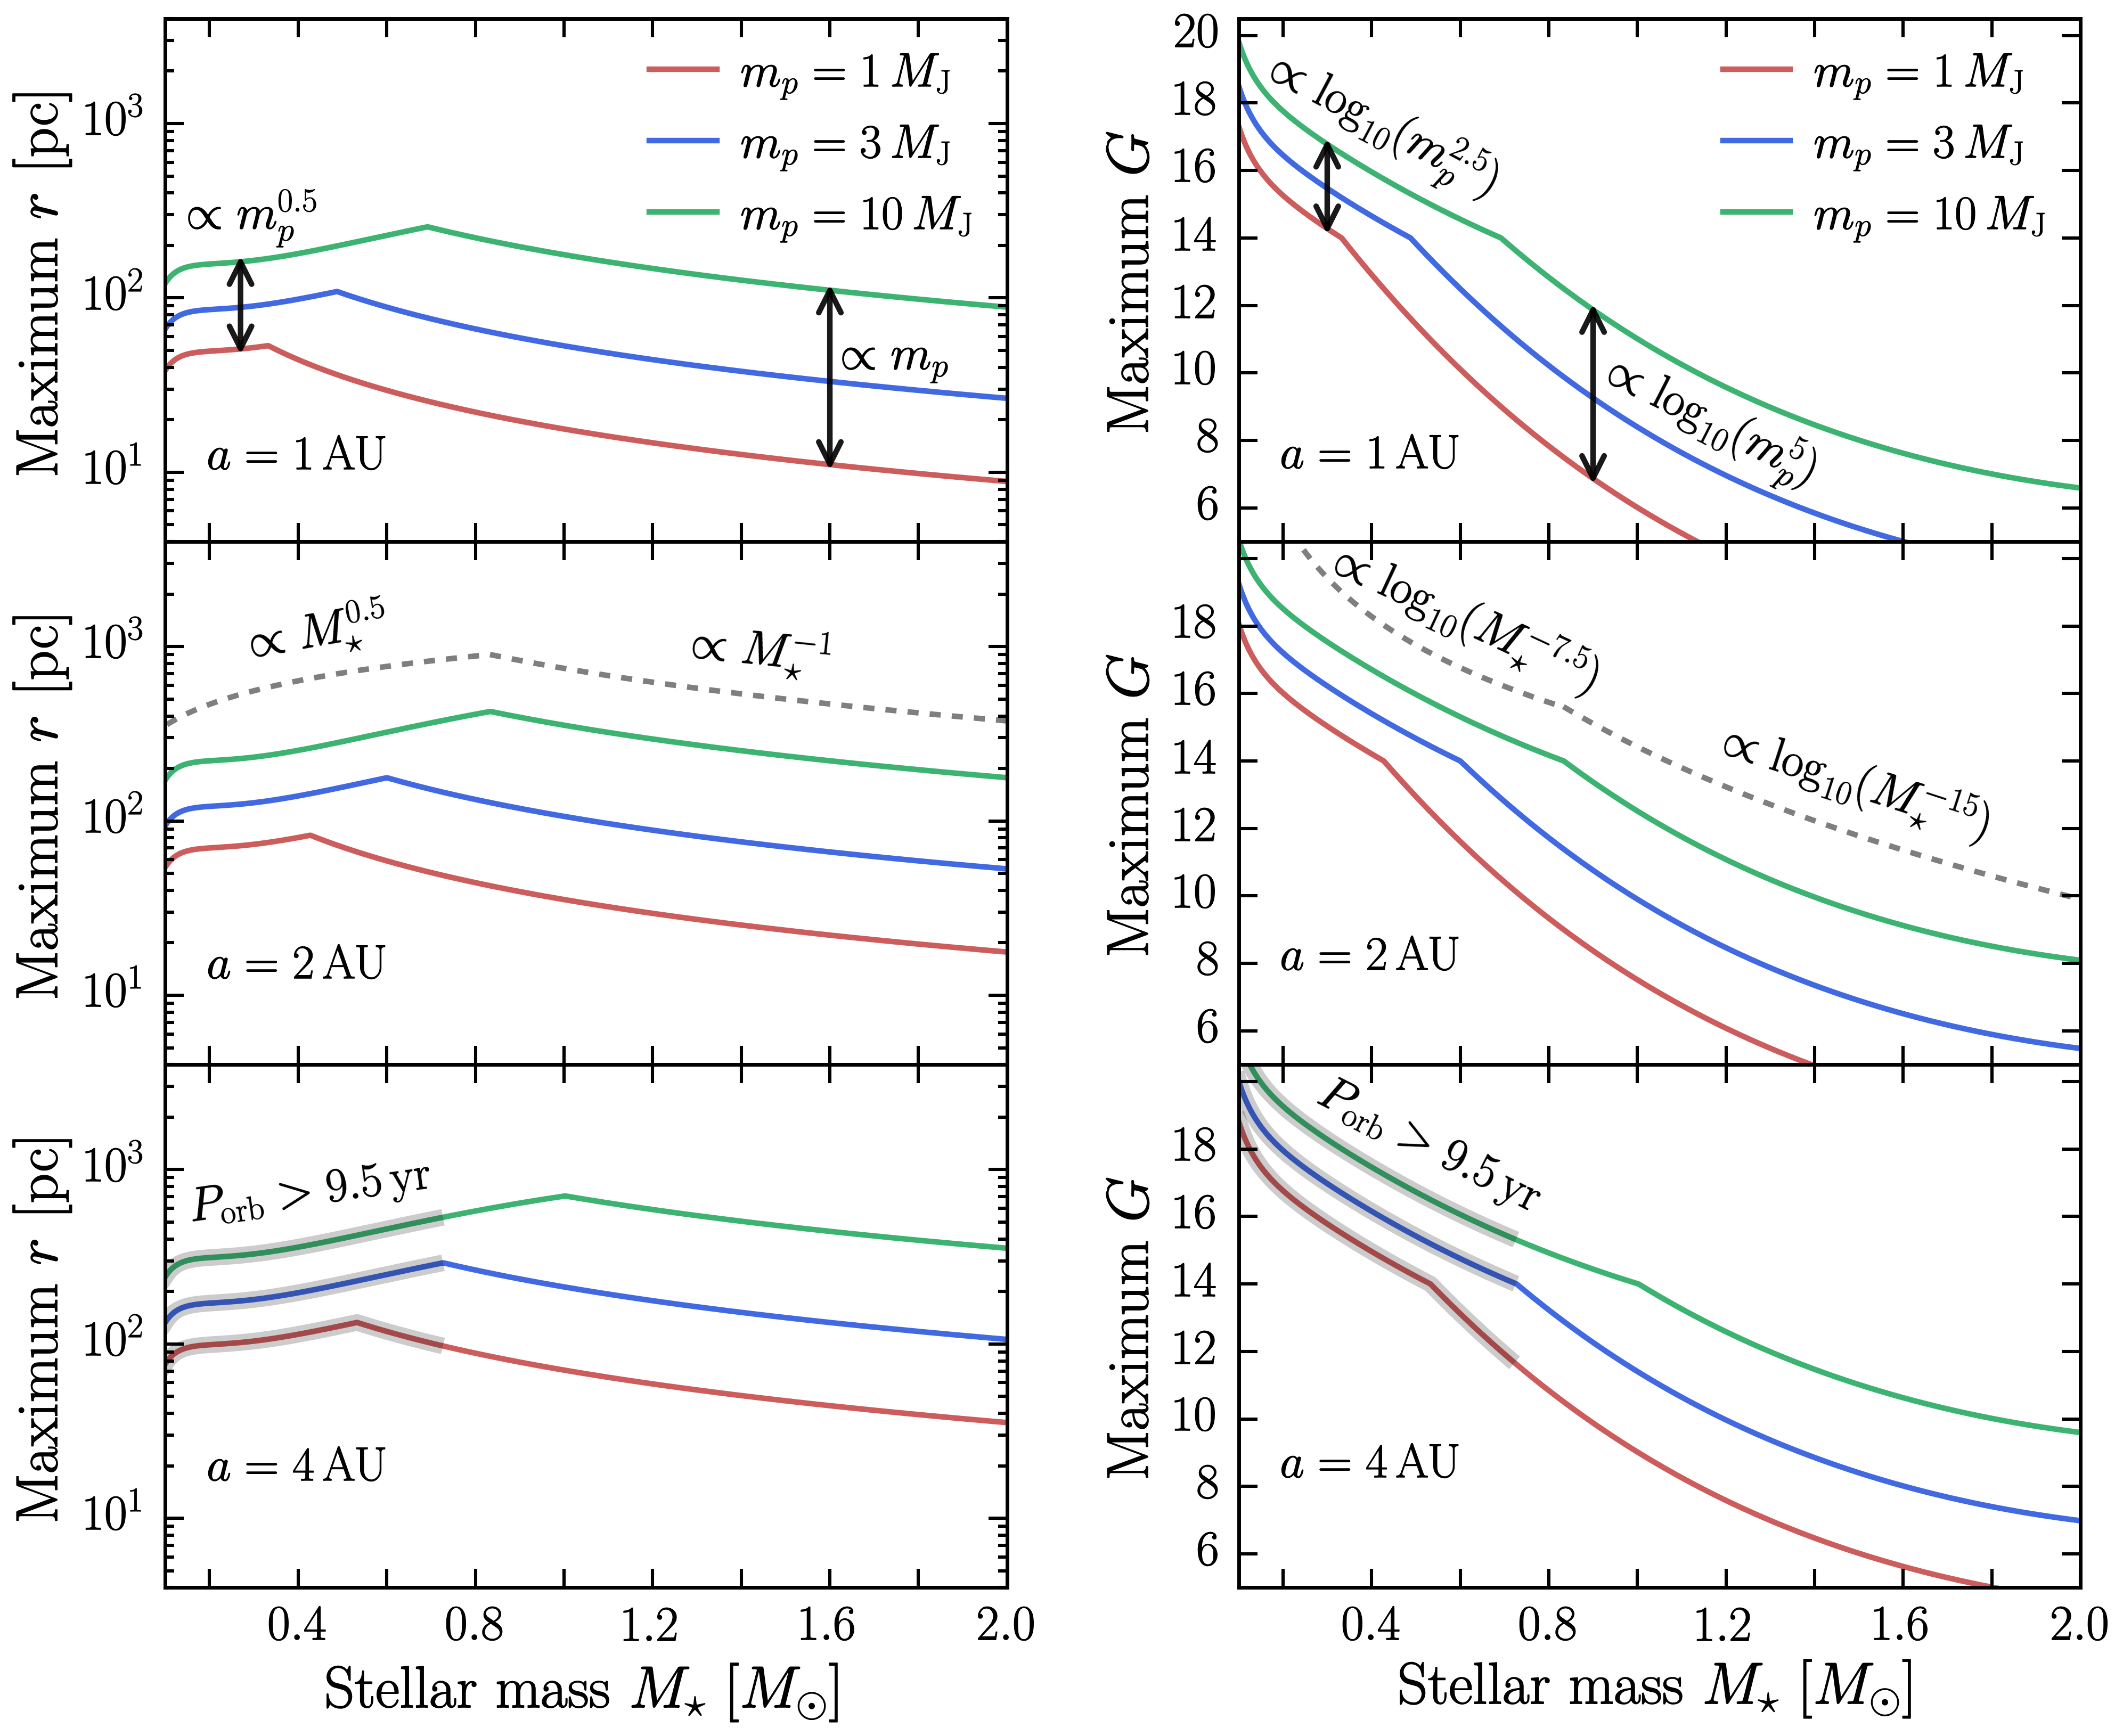

In [7]:
# make plot
fig, axes = plt.subplots(3, 2, figsize=(13.65*1.18, 11.8*1.18*0.95), dpi=250, sharex=True, facecolor='white')  # Adjust figsize as needed

plot_panel(axes[0,0], axes[0,1], 1.0, N_sigma=1.0, line_labels=True, remove_G_20_label=False)
plot_panel(axes[1,0], axes[1,1], 2.0, N_sigma=1.0, line_labels=False, remove_G_20_label=True)
plot_panel(axes[2,0], axes[2,1], 4.0, N_sigma=1.0, line_labels=False, remove_G_20_label=True)

# add scaling relations
axes[1,0].plot(np.linspace(0.03, 0.833, 1000), (750/(0.833**1.5))*np.sqrt(np.linspace(0.06, 0.833, 1000)), c='k', lw=3, ls='--', alpha=0.5)
axes[1,0].plot(np.linspace(0.833, 2.0, 1000), 750/np.linspace(0.833, 2.0, 1000), c='k', lw=3, ls='--', alpha=0.5)
axes[1,0].text(0.45, 1200, r'$\propto M_\star^{0.5}$', rotation=10, horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[1,0].text(1.45, 930, r'$\propto M_\star^{-1}$', rotation=-6, horizontalalignment='center', verticalalignment='center', fontsize=26)

axes[1,1].plot(np.linspace(0.09, 0.833, 1000), -7.5*np.log10(np.linspace(0.03, 0.833, 1000))+15.0, c='k', lw=3, ls='--', alpha=0.5)
axes[1,1].plot(np.linspace(0.833, 2.0, 1000), -15.0*np.log10(np.linspace(0.833, 2.0, 1000))+14.42, c='k', lw=3, ls='--', alpha=0.5)
axes[1,1].text(0.62, 18.13, r'$\propto \log_{10}(M_\star^{-7.5})$', rotation=-25, horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[1,1].text(1.5, 13.3, r'$\propto \log_{10}(M_\star^{-15})$', rotation=-18, horizontalalignment='center', verticalalignment='center', fontsize=26)

# add semi-major axis labels
axes[0,0].text(0.4, 12, r'$a = 1\,\mathrm{AU}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[0,1].text(0.4, 7.5, r'$a = 1\,\mathrm{AU}$', horizontalalignment='center', verticalalignment='center', fontsize=26)

axes[1,0].text(0.4, 12.0*1.20, r'$a = 2\,\mathrm{AU}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[1,1].text(0.4, 8.13, r'$a = 2\,\mathrm{AU}$', horizontalalignment='center', verticalalignment='center', fontsize=26)

axes[2,0].text(0.4, 19.0, r'$a = 4\,\mathrm{AU}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[2,1].text(0.4, 8.6, r'$a = 4\,\mathrm{AU}$', horizontalalignment='center', verticalalignment='center', fontsize=26)

axes[2,0].text(0.43, 650*1.13, r'$P_\mathrm{orb} > 9.5\,\mathrm{yr}$', rotation=8, horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[2,1].text(0.532, 17.85*1.01, r'$P_\mathrm{orb} > 9.5\,\mathrm{yr}$', rotation=-27, horizontalalignment='center', verticalalignment='center', fontsize=26)

# add arrows
x_mid, y_mid = 1.6, 27.8*1.196
y_low  = y_mid - (y_mid - y_mid/(3.0*1.08))
y_high = y_mid + (y_mid*(3.3333333*1.08) - y_mid)
axes[0,0].annotate('', xy=(x_mid, y_high), xytext=(x_mid, y_low) ,arrowprops=dict(arrowstyle='<->', lw=3, shrinkA=0, shrinkB=0, mutation_scale=30, alpha=0.9, color='k'), zorder=10)
axes[0,0].text(1.75, 36*1.196, r'$\propto m_p$', rotation=0, horizontalalignment='center', verticalalignment='center', fontsize=26)

x_mid, y_mid = 0.27, 81*1.092
y_low  = y_mid - (y_mid - y_mid/(np.sqrt(3.0)*1.08))
y_high = y_mid + (y_mid*(np.sqrt(3.3333333)*1.08) - y_mid)
axes[0,0].annotate('', xy=(x_mid, y_high), xytext=(x_mid, y_low),arrowprops=dict(arrowstyle='<->', lw=3, shrinkA=0, shrinkB=0, mutation_scale=30, alpha=0.9, color='k'), zorder=10)
axes[0,0].text(0.30, 260*1.092, r'$\propto m_p^{0.5}$', rotation=0, horizontalalignment='center', verticalalignment='center', fontsize=26)

x_mid, y_mid = 0.9, 8.88*1.042
y_low  = y_mid - 5.0*np.log10(3.0)*1.07
y_high = y_mid + 5.0*np.log10(3.3333333)*1.07
axes[0,1].annotate('', xy=(x_mid, y_high), xytext=(x_mid, y_low),arrowprops=dict(arrowstyle='<->', lw=3, shrinkA=0, shrinkB=0, mutation_scale=30, alpha=0.9, color='k'), zorder=10)
axes[0,1].text(1.17, 8.1*1.042, r'$\propto \log_{10}(m_p^5)$', rotation=-27, horizontalalignment='center', verticalalignment='center', fontsize=26)

x_mid, y_mid = 0.3, 15.26*1.013
y_low  = y_mid - 2.5*np.log10(3.0)*1.14
y_high = y_mid + 2.5*np.log10(3.3333333)*1.14
axes[0,1].annotate('', xy=(x_mid, y_high), xytext=(x_mid, y_low),arrowprops=dict(arrowstyle='<->', lw=3, shrinkA=0, shrinkB=0, mutation_scale=30, alpha=0.9, color='k'), zorder=10)
axes[0,1].text(0.43, 17.0*1.013, r'$\propto \log_{10}(m_p^{2.5})$', rotation=-28, horizontalalignment='center', verticalalignment='center', fontsize=26)

plt.tight_layout()
plt.subplots_adjust(hspace=0.0, wspace=0.275) 
plt.show()